2025/10/08: 

* Switched model from through-origin linear regression to **fine regression (add intercept b)** so prediction becomes ( \hat y = w^\top x + b ).
  • Implemented (b) in both DRO-SVR and empirical ε-SVR.
  • Immediate symptom improvement expected: remove systematic bias from forcing intercept=0.

* Found **DRO exploded (huge |b|, tiny ‖w‖)**. Root cause: a **sign error**—I placed (+a[j]\cdot b) on the **right** of the inequality.
  • Fix: keep (+a[j]\cdot b) **on the left**:
  `S + ... + a[j]*b0 <= s[i]`.
  • After fix, DRO loss dropped but was still much larger than empirical.

* Diagnosed **over-conservatism from joint uncertainty on (x,y)** with equal metric weights (effectively κ=1). Because (y) scale ≫ (x), adversary over-uses the y-axis.
  • Introduced **κ** in the ground cost to penalize moving (y): enforce dual constraint
  `||[p, u/kappa]||₂ ≤ λ`.
  • Observation: solver sometimes unstable (MOSEK fails). Added **stability**: tiny ridge on λ (`lam_ridge=1e-8`), used explicit SOC, and **fallback to SCS** if MOSEK fails.

* Still saw “constant model” behavior (‖w‖≈0, b≈mean(y)). Root cause: I also let **y move inside the support set** (box on Z=[x;y]), creating **double relaxation** (support + κ).
  • set **Ξ = X × ℝ** (support only on x).
  • Practically: use box only for **X** (first n dims) inside the support function; do **not** give y a box.
  • Because (Y=\mathbb{R}), the support function is finite only if **z_y=0** ⇒ **enforce (u=-a[j])**. I eliminated u as a variable by substituting `u_const = -a[j]`.

* With Ξ = X×ℝ + (u=-a[j]) + two segments + intercept on the left, I tuned robustness:
  • **ρ as the main knob**:
  – Large ρ or very wide X-box ⇒ adversary “squeezes x” ⇒ model collapses to constant predictor (‖w‖→0, b≈E[y]).
  – Decreasing ρ revived ‖w‖; at **ρ=0.5** test loss is the best.
  • **κ as a secondary knob**:
  – Observed weak sensitivity of results to κ when ρ is small/moderate and X-box not wide. Reason: dual bound `λ ≥ sqrt(‖p‖² + (1/κ)²)` is **dominated by ‖p‖**, so `1/κ` is negligible.
  – Verified theory by setting **ρ=0**: DRO ≈ empirical (tiny differences only from the λ-ridge), confirming correctness.

* Clarified **why empirical/test loss levels look “large”** (e.g., 25k–50k):
  • With noise σ=80k and ε=60k, even a perfect model has expected ε-loss ≈ **20.9k**/sample (from Gaussian tail calculation).
  • Covariate shift + changed true coefficients in the test generator increase loss further. So 25k–50k is **normal** for this setup.

* Explored **ε as a tolerance knob**: increasing ε directly lowers average ε-loss (e.g., ε=80k ⇒ ≈13.3k baseline), at the cost of fewer support vectors / potentially smoother (risk of underfit).
  • Recommendation: choose ε around the residual scale (e.g., 0.75–1.25×σ), validate jointly with ρ.

* Current best validation behavior: **ρ ≈ 0.5** produced the strongest test performance; under this ρ, **κ has little effect** because `‖p‖` dominates `1/κ`.
  • I confirmed **ρ=0** reproduces empirical almost exactly (sanity check), so the DRO pipeline is correct.

* Solver robustness measures that remained in place:
  • `lam_ridge=1e-8` (can set to 0 when stable), explicit `cp.SOC(lam, ...)`, fallback to SCS if MOSEK fails.
  • Intercept always on the **LHS** of constraints; only **two ε-segments**; **Ξ = X×ℝ**; **u eliminated as u=−a[j]**.

**Final snapshot (today):**

* Separable ground cost with κ, **Ξ = X×ℝ**, dual SOC with `u/κ`, `u=−a[j]`, two-segment ε-loss, intercept included.
* With **ρ=0.5** and reasonable X-box, DRO test loss is **more stable under shift**.
* κ scanning at this ρ shows little change; ε remains a strong lever to set loss scale.

In [242]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

#### Parameters Setting

In [243]:
rng = np.random.default_rng(seed=42)

number_dimension = 5    # dimension of x
number_batch = 3   # number of batches at each time
batch_size = 100   # number of samples in each batch
N = number_batch * batch_size   # total number of samples

decay_rate = 0.9    # decay rate for forgetting past data

#### Train Set Construction

In [244]:
# 1. mu_x
mu_x = np.array([
    rng.uniform(80, 120),   # average area ~100 m2
    rng.uniform(3, 6),      # average number of rooms ~4-5
    rng.uniform(20, 50),    # average age of house ~30 years
    rng.uniform(2, 8),      # average distance from downtown ~5 km
    rng.uniform(0.4, 0.8)   # average renovation status ~0.6
])

# 2. Sigma_x, use A @ A^T to ensure positive definite
A = rng.normal(0, 1, size=(number_dimension, number_dimension))
Sigma_x = A @ A.T + np.diag([30, 1, 15, 2, 0.1])  # add feature-specific variance to ensure realistic scale for each dimension

# 3. easy and realistic w_true, noise
w_true = np.array([6000, 50000, -2000, -10000, 150000])         # price coefficients
sigma_eps = 80000.0                                             # noise std of y|x

# 4. joint normal distribution (mu_joint_hat, Sigma_joint_hat)
mu_y = float(mu_x @ w_true)                                     # scalar
Sigma_xy = Sigma_x @ w_true                                     # shape (n,)
Sigma_yy = float(w_true.T @ Sigma_x @ w_true + sigma_eps**2)    # scalar

mu_joint_hat = np.hstack([mu_x, mu_y])                          # shape (n+1,)
Sigma_joint_hat = np.block([
    [Sigma_x,                 Sigma_xy.reshape(-1, 1)],
    [Sigma_xy.reshape(1, -1), np.array([[Sigma_yy]])   ]
])

# 5. Sample N pairs (xi, yi) from the joint normal distribution
def sample_joint_gaussian(rng, mu_joint, Sigma_joint, N):
    Z = rng.multivariate_normal(mean=mu_joint, cov=Sigma_joint, size=N)     # shape (N, n+1)
    return Z[:, :number_dimension], Z[:, number_dimension], Z

#### Comparison of DRO Regression and Empirical Regression

In [245]:
# ---------- Helper Functions ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

# 2. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw_weights = decay ** (now_t - time_idx)
    pi = raw_weights / raw_weights.sum()
    return pi

# 3. DRO ε-insensitive SVR
def solve_dro_svr(X_all, y_all, ell, upp, pi,
                  epsilon=80000.0, rho=50.0,
                  kappa=1e5,              # 挪 y 的成本（越大=越难动 y）
                  lam_ridge=1e-8,         # 极小正则，稳数值
                  use_mosek=True):
    """
    论文式 DRO-SVR（ε-insensitive）：
    - Ξ = X × R ⇒ 支撑函数只对 x；
    - 可分代价 ⇒ 对偶范数约束里使用 u/kappa；
    - 由于 Y=R，必须有 z_y = -a[j]-u = 0 ⇒ u = -a[j]（这里直接消元）。
    """
    N, n = X_all.shape
    a = np.array([1.0, -1.0, 0.0])          # 三段系数
    b_eps = np.array([-epsilon, -epsilon, 0.0])
    J = len(a)

    w   = cp.Variable(n)
    b0  = cp.Variable()
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    # 对偶变量：仅 p 对应 x；u 用常数 -a[j] 直接消元
    p   = cp.Variable((N*J, n))

    # 只取 x 的 box（Ξ = X × R）
    ell_x = ell[:n]
    upp_x = upp[:n]

    cons = []
    for i in range(N):
        xi = X_all[i]
        yi = y_all[i]
        for j in range(J):
            k = i*J + j

            # x 向的“梯度差”
            v_x = a[j]*w - p[k, :]

            # S_X(v_x)
            t_pos = cp.Variable(n, nonneg=True)
            t_neg = cp.Variable(n, nonneg=True)
            cons += [t_pos - t_neg == v_x]
            S_x = upp_x @ t_pos + (-ell_x) @ t_neg

            # 这里用 u = -a[j]
            u_const = -a[j]

            # 对偶范数约束：|| [p, u/kappa] ||_2 ≤ lam
            soc_vec = cp.hstack([p[k, :], u_const / kappa])

            # 约束（截距 a[j]*b0 在左侧）
            cons += [
                S_x + b_eps[j] + p[k, :] @ xi + u_const*yi + a[j]*b0 <= s[i],
                cp.SOC(lam, soc_vec)
            ]

    obj = cp.Minimize(lam * rho + cp.sum(cp.multiply(pi, s)) + lam_ridge * lam)
    prob = cp.Problem(obj, cons)

    solved = False
    if use_mosek:
        try:
            prob.solve(solver=cp.MOSEK, verbose=False)
            solved = True
        except cp.error.SolverError:
            solved = False
    if not solved:
        prob.solve(solver=cp.SCS, verbose=False, eps=1e-5, max_iters=5000)

    return (w.value, b0.value), prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=80000.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w  = cp.Variable(n)
    b0 = cp.Variable()
    resid = y - (X @ w + b0)
    loss  = cp.pos(cp.abs(resid) - epsilon)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        obj = cp.Minimize(sw @ loss)

    prob = cp.Problem(obj)
    prob.solve(solver=cp.MOSEK if use_mosek else cp.GUROBI, verbose=False)
    return (w.value, b0.value), prob.status


# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [246]:
# ---------- Rolling Over Time ----------

T = 5  # total time steps
q = decay_rate

X_all_list, y_all_list, Z_all_list, time_idx_list = [], [], [], []
w_series, w_emp_series = [], []
loss_mean_rob, loss_sem_rob = [], []
loss_mean_emp, loss_sem_emp = [], []

for t in range(T):
    # (1) Sample N new pairs (X_t, y_t)
    X_t, y_t, Z_t = sample_joint_gaussian(rng, mu_joint_hat, Sigma_joint_hat, N)

    # (2) Append to historical pool
    X_all_list.append(X_t)
    y_all_list.append(y_t)
    Z_all_list.append(Z_t)
    time_idx_list.append(np.full(N, t, dtype=int))

    # (3) Merge all samples up to now
    X_all = np.vstack(X_all_list)
    y_all = np.concatenate(y_all_list)
    Z_all = np.vstack(Z_all_list)
    time_idx = np.concatenate(time_idx_list)

    # (4) Rebuild uncertainty set Ξ
    ell, upp = build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02)

    # (5) Compute time-dependent weights
    pi_t = time_weights_from_indices(time_idx, now_t=t, decay=q)

    # (6) Solve DRO-SVR
    (w_t, b_t), status = solve_dro_svr(
        X_all, y_all, ell, upp, pi_t,
        epsilon=80000.0, rho=0.5,
        kappa=1e4,          # 推荐先试 1e4~1e5（未标准化且 y≈1e6 量级）
        lam_ridge=1e-8,     # 保持打开更稳；很稳后可设 0
        use_mosek=True
    )
    w_series.append((w_t, b_t))
    print(f"[t={t}] DRO-SVR solved (status={status}), ||w||₂ = {np.linalg.norm(w_t):.3e}, b = {b_t:.2f}")

    # (7) Empirical ε-SVR
    (w_emp, b_emp), status_emp = solve_empirical_svr_noreg(
        X_all, y_all, epsilon=80000.0, sample_weights=pi_t
    )
    w_emp_series.append((w_emp, b_emp))
    print(f"[t={t}] Empirical SVR solved (status={status_emp}), ||w||₂ = {np.linalg.norm(w_emp):.3e}, b = {b_emp:.2f}")

    # (8) Compute losses on current batch
    y_pred_rob = X_t @ w_t + b_t
    y_pred_emp = X_t @ w_emp + b_emp
    L_t_rob = eps_ins_loss(y_t, y_pred_rob, eps=80000.0)
    L_t_emp = eps_ins_loss(y_t, y_pred_emp, eps=80000.0)
    loss_mean_rob.append(L_t_rob.mean())
    loss_sem_rob.append(L_t_rob.std(ddof=1) / np.sqrt(len(L_t_rob)))
    loss_mean_emp.append(L_t_emp.mean())
    loss_sem_emp.append(L_t_emp.std(ddof=1) / np.sqrt(len(L_t_emp)))

[t=0] DRO-SVR solved (status=optimal), ||w||₂ = 9.581e+04, b = 35010.00
[t=0] Empirical SVR solved (status=optimal), ||w||₂ = 1.588e+05, b = 26811.18
[t=1] DRO-SVR solved (status=optimal), ||w||₂ = 9.100e+04, b = -148962.46
[t=1] Empirical SVR solved (status=optimal), ||w||₂ = 1.565e+05, b = -162246.18
[t=2] DRO-SVR solved (status=optimal), ||w||₂ = 8.661e+04, b = -53835.21
[t=2] Empirical SVR solved (status=optimal), ||w||₂ = 1.540e+05, b = -16983.16
[t=3] DRO-SVR solved (status=optimal), ||w||₂ = 8.627e+04, b = -61089.19
[t=3] Empirical SVR solved (status=optimal), ||w||₂ = 1.536e+05, b = -72026.83
[t=4] DRO-SVR solved (status=optimal), ||w||₂ = 8.671e+04, b = -72328.50
[t=4] Empirical SVR solved (status=optimal), ||w||₂ = 1.567e+05, b = -29458.97


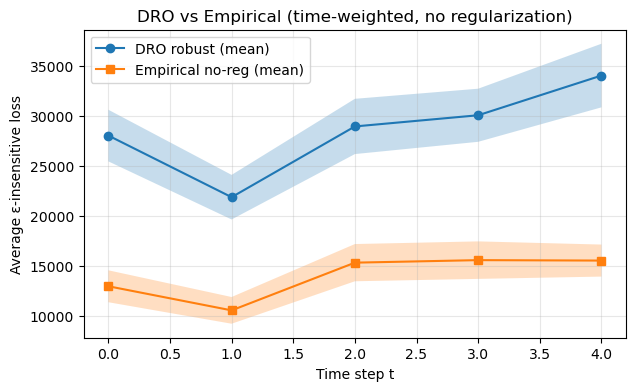

In [247]:
# ---------- Visualization ----------

t_axis = np.arange(T)
plt.figure(figsize=(7, 4))

# DRO
plt.plot(t_axis, loss_mean_rob, marker="o", label="DRO robust (mean)")
plt.fill_between(t_axis,
                 np.array(loss_mean_rob)-np.array(loss_sem_rob),
                 np.array(loss_mean_rob)+np.array(loss_sem_rob),
                 alpha=0.25)

# Empirical
plt.plot(t_axis, loss_mean_emp, marker="s", label="Empirical no-reg (mean)")
plt.fill_between(t_axis,
                 np.array(loss_mean_emp)-np.array(loss_sem_emp),
                 np.array(loss_mean_emp)+np.array(loss_sem_emp),
                 alpha=0.25)

plt.xlabel("Time step t")
plt.ylabel("Average ε-insensitive loss")
plt.title("DRO vs Empirical (time-weighted, no regularization)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Test Set Construction

In [248]:
def random_covariate_shift_matrix(dim, rng,
                                  scale_range=(0.7, 1.4),
                                  shear_std=0.2):

    # diagonal scaling
    scales = rng.uniform(scale_range[0], scale_range[1], size=dim)
    D = np.diag(scales)

    # shear (upper triangular with zeros on diag)
    S = np.triu(rng.normal(0.0, shear_std, size=(dim, dim)), k=1)
    A = D @ (np.eye(dim) + S)
    return A

def make_psd(S, eps=1e-10):
    S = 0.5 * (S + S.T)
    vals, vecs = np.linalg.eigh(S)
    vals = np.maximum(vals, eps) 
    return (vecs * vals) @ vecs.T

# Non-orthogonal transform A for test
A = random_covariate_shift_matrix(number_dimension, rng,
                                  scale_range=(0.7, 1.4), shear_std=0.25)

# Test covariance under covariate shift
Sigma_x_test = A @ Sigma_x @ A.T

# Rebuild joint covariance for test
w_true_test = w_true.copy()
w_true_test[4] *= 0.6   # renovation impact ↓40%
w_true_test[2] *= 1.3   # age penalty ↑30%
w_true_test[3] *= 1.2   # distance penalty ↑20%

Sigma_xy_test = Sigma_x_test @ w_true_test
Sigma_yy_test = float(w_true_test.T @ Sigma_x_test @ w_true_test + sigma_eps**2)
mu_joint_test = np.hstack([mu_x, float(mu_x @ w_true_test)])

Sigma_joint_test = np.block([
    [Sigma_x_test,                 Sigma_xy_test.reshape(-1, 1)],
    [Sigma_xy_test.reshape(1, -1), np.array([[Sigma_yy_test]])]
])
Sigma_joint_test = make_psd(Sigma_joint_test)

N_test_total = 1000
X_test_all, y_test_all, Z_test_all = sample_joint_gaussian(
    rng, mu_joint_test, Sigma_joint_test, N_test_total
)

T_test = T  # use same number of bins as training time steps
perm = rng.permutation(N_test_total)
splits = np.array_split(perm, T_test)   # split into T_test parts

#### Evaluate DRO & Empirical models on the rotated test set

[test-bin 0] N=200 | mean loss DRO=29995.65, Emp=34381.35
[test-bin 1] N=200 | mean loss DRO=25183.48, Emp=36003.27
[test-bin 2] N=200 | mean loss DRO=27763.09, Emp=33669.94
[test-bin 3] N=200 | mean loss DRO=28332.06, Emp=33794.01
[test-bin 4] N=200 | mean loss DRO=26548.46, Emp=38440.78


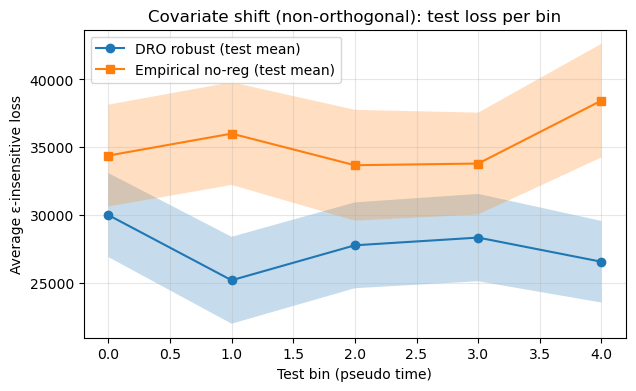

In [249]:
test_mean_rob, test_sem_rob = [], []
test_mean_emp, test_sem_emp = [], []

for t in range(T_test):
    idx = splits[t]
    X_bin = X_test_all[idx]
    y_bin = y_test_all[idx]

    w_rob, b_rob = w_series[t]
    w_emp, b_emp = w_emp_series[t]

    # predict
    y_rob_test_pred = X_bin @ w_rob + b_rob
    y_emp_test_pred = X_bin @ w_emp + b_emp

    # ε-insensitive loss per bin
    L_rob_test = eps_ins_loss(y_bin, y_rob_test_pred, eps=80000.0)
    L_emp_test = eps_ins_loss(y_bin, y_emp_test_pred, eps=80000.0)

    # aggregate: mean and standard error
    test_mean_rob.append(L_rob_test.mean())
    test_sem_rob.append(L_rob_test.std(ddof=1) / np.sqrt(len(L_rob_test)))
    test_mean_emp.append(L_emp_test.mean())
    test_sem_emp.append(L_emp_test.std(ddof=1) / np.sqrt(len(L_emp_test)))

    print(f"[test-bin {t}] N={len(idx)} | mean loss DRO={test_mean_rob[-1]:.2f}, Emp={test_mean_emp[-1]:.2f}")

t_axis = np.arange(T_test)
plt.figure(figsize=(7, 4))

# DRO on test
plt.plot(t_axis, test_mean_rob, marker="o", label="DRO robust (test mean)")
plt.fill_between(t_axis,
                 np.array(test_mean_rob) - np.array(test_sem_rob),
                 np.array(test_mean_rob) + np.array(test_sem_rob),
                 alpha=0.25)

# Empirical on test
plt.plot(t_axis, test_mean_emp, marker="s", label="Empirical no-reg (test mean)")
plt.fill_between(t_axis,
                 np.array(test_mean_emp) - np.array(test_sem_emp),
                 np.array(test_mean_emp) + np.array(test_sem_emp),
                 alpha=0.25)

plt.xlabel("Test bin (pseudo time)")
plt.ylabel("Average ε-insensitive loss")
plt.title("Covariate shift (non-orthogonal): test loss per bin")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()